# Seleção de Atributos
Objetivo: Avaliar os atributos mais relevantes para o desempenho acadêmico utilizando testes estatísticos e regressões com base nos módulos existentes.

## Importações e Configurações Iniciais

In [1]:
# Permite importar módulos .py que estão na raiz do repositório 

import sys, pathlib
ROOT = pathlib.Path().resolve().parents[1] 
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [2]:
#Importação dos módulos desenvolvidos

from pre_modelagem import *
from eda_functions import *
from feature_selection import *

# Bibliotecas

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [3]:
#Import base

#materia =  'matematica' 
materia = 'portugues'
#cor_paleta = 'verde' 
cor_paleta = 'azul'
df = importar_base(materia)

df_original = df.copy() 

In [4]:
# Base com pre-processamento
df_pp = preparar_dados(df_original,classificacao=False)
df_o = df_pp.copy() 

1    549
0    100
Name: aprovacao, dtype: int64


In [5]:
df_pc = preparar_dados(df,classificacao=True)

type(df_pc)

1    549
0    100
Name: aprovacao, dtype: int64
1    549
0    100
Name: aprovacao, dtype: int64


pandas.core.frame.DataFrame

In [6]:
df_pc['aprovacao'].value_counts()

1    549
0    100
Name: aprovacao, dtype: int64

# 2. Síntese dos resultados EDA


 - As notas apresentaram distribuições não normais segundo Shapiro-Wilk
 - Algumas variáveis categóricas demonstraram associação com aprovação
 - Multicolinearidade ainda será avaliada neste notebook


## 3. Avaliação de multicolinearidade
- Análise de VIF e correlação para identificar redundâncias entre as variáveis.

In [7]:
# Remove variáveis-alvo antes da análise de VIF/correlação entre preditores
variaveis_target = ['nota1', 'nota2', 'nota_final']
df_preditores = df_pp.drop(columns=variaveis_target)


print('limiar coeficiente de correlação > 0.6')
resumo, vif_df =  relatorio_multicolinearidade(df_preditores,limite_corr=0.6)
    
display(resumo[resumo['avaliacao'] != 'Sem alerta'])


limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.647477
189,alcool_fim_semana,alcool_dias_uteis,0.616561
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.709455


,variavel,vif,Alta correlação com,avaliacao
0,idade,75.700824,—,VIF elevado
15,relacao_familiar,19.645464,—,VIF elevado
2,escolaridade_mae,15.864643,escolaridade_pai,VIF alto + correlação alta
16,tempo_livre,12.357453,—,VIF elevado
17,frequencia_saidas,12.081671,—,VIF elevado
12,intencao_superior,11.333853,—,VIF elevado
3,escolaridade_pai,11.308704,escolaridade_mae,VIF alto + correlação alta
30,profissao_pai_Outra profissão,10.350741,profissao_pai_Serviços,VIF alto + correlação alta
19,alcool_fim_semana,8.724827,alcool_dias_uteis,VIF alto + correlação alta
5,tempo_estudo,7.879912,—,VIF elevado


In [8]:
variaveis_alta_colineariedade = [
            #'escolaridade_mae',
            'escolaridade_pai',
            'alcool_fim_semana',
            #'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [9]:
corr = df_o[variaveis_alta_colineariedade + variaveis_target].corr()

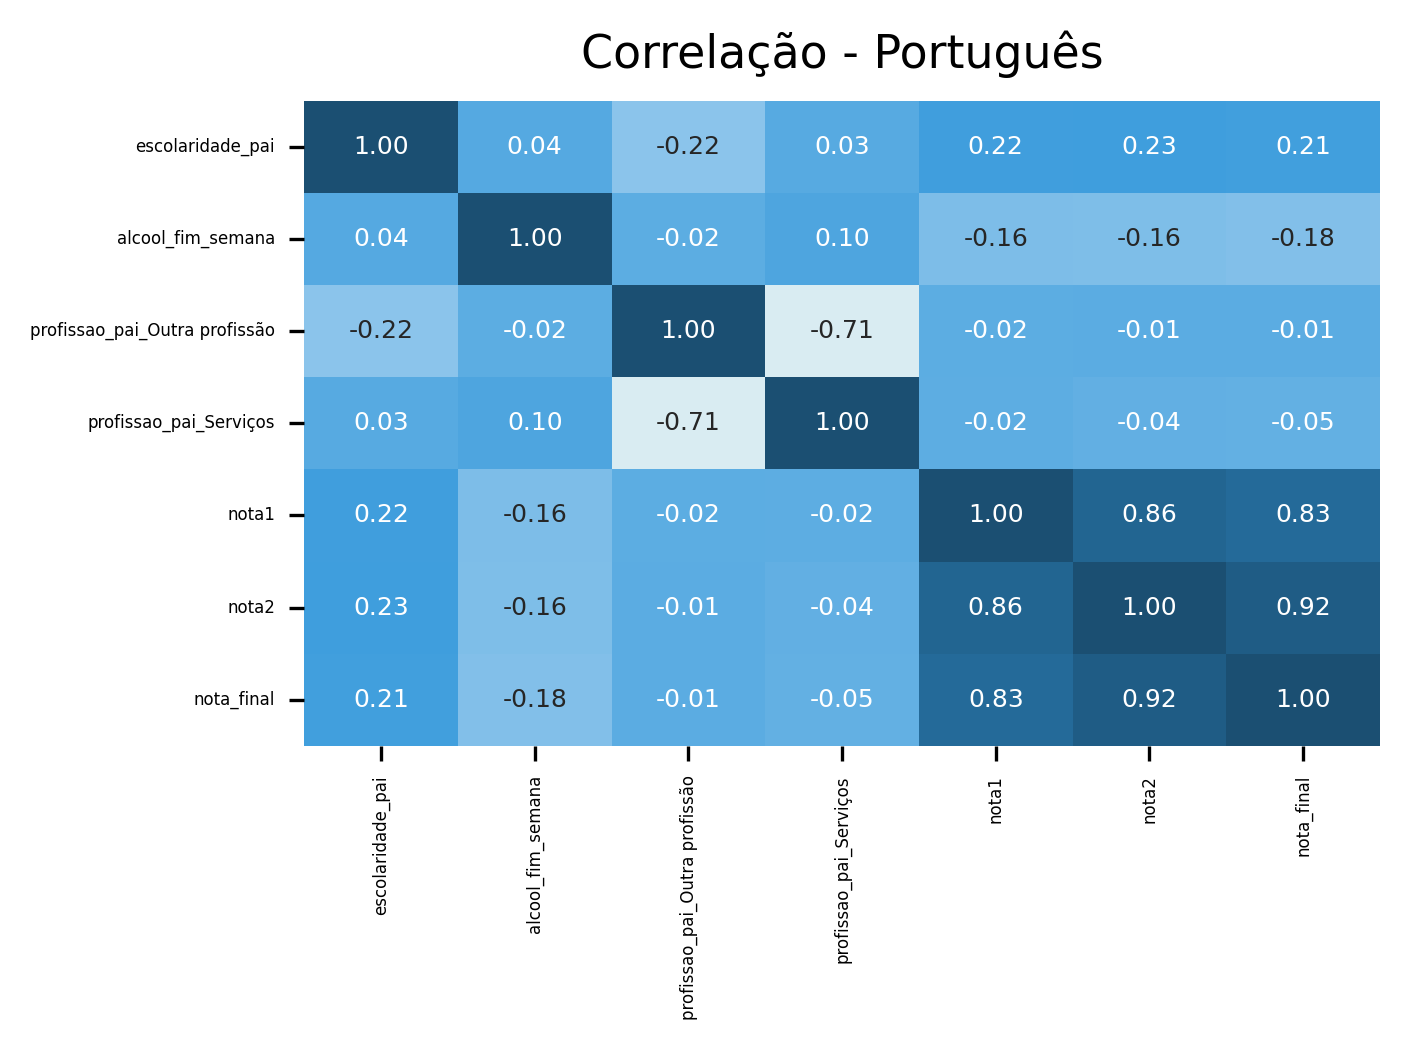

In [10]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

# 4. Regressão: nota1 -> nota2



## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1922.
Date:                Tue, 06 May 2025   Prob (F-statistic):          6.37e-196
Time:                        04:53:38   Log-Likelihood:                -1166.9
No. Observations:                 649   AIC:                             2338.
Df Residuals:                     647   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1054      0.245      4.503      0.0

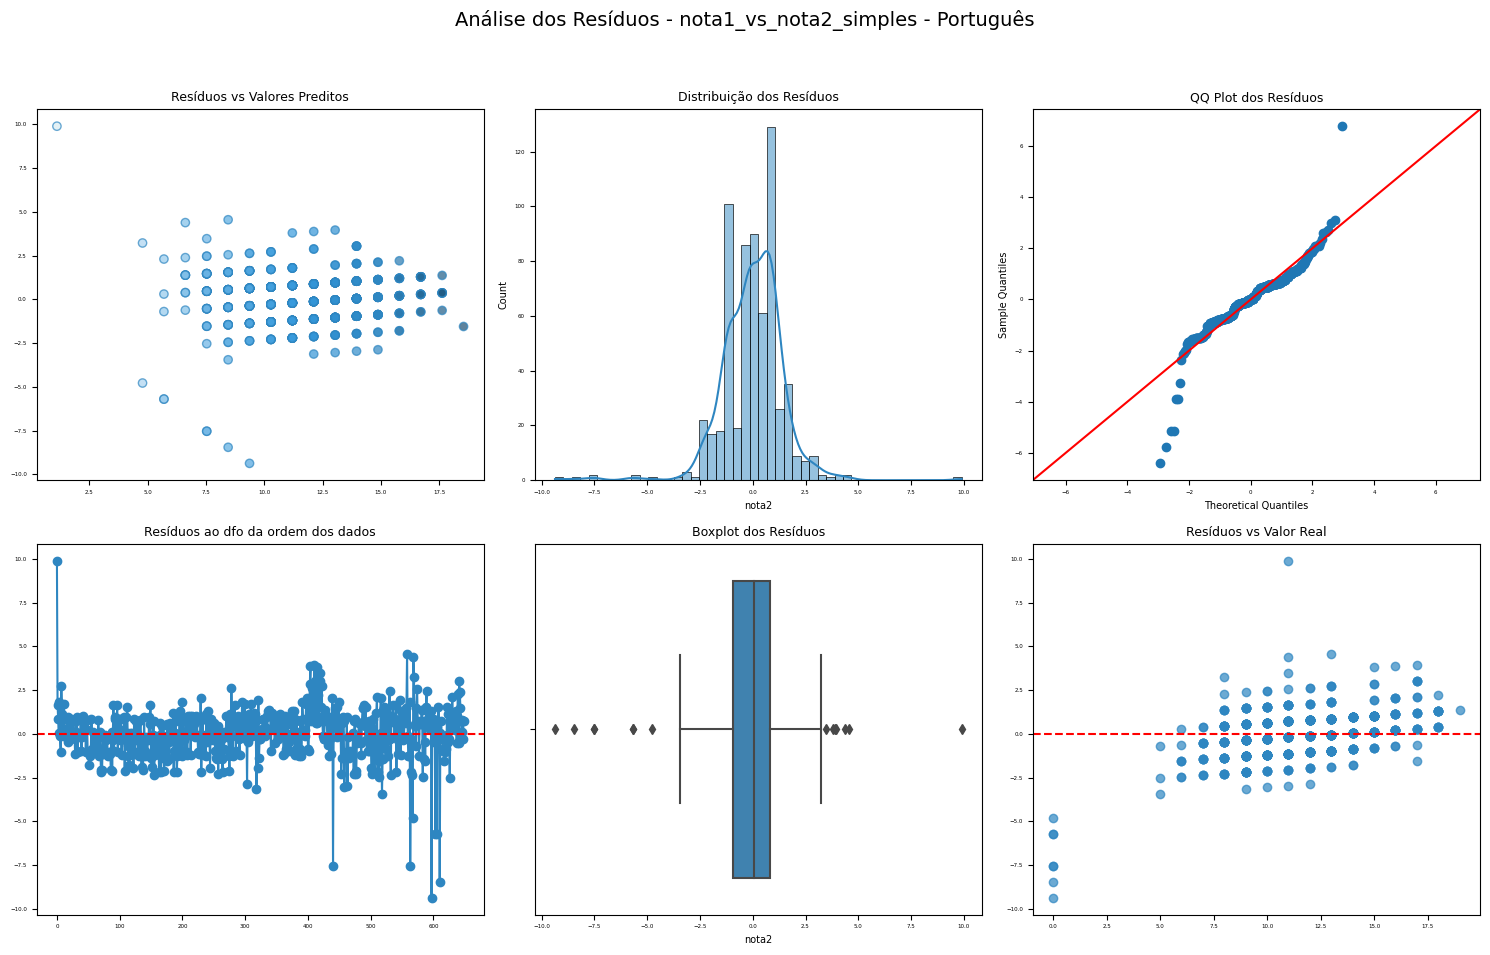

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,4.926722e-16,0.895378,Não normal,1.404065e-09,Heteroscedástico,1.669422,OK,10


In [11]:
modelo_m = regressao_multipla(df, target='nota2', variaveis=['nota1'])
print(modelo_m.summary())

avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_nota2_simples', materia=materia)

## 4.2. Regressão múltipla com nota1 e variáveis adicionais
- Objetivo: Avaliar estabilidade dos coeficientes da nota1 e identificar covariáveis explicativas para nota2.

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1922.
Date:                Tue, 06 May 2025   Prob (F-statistic):          6.37e-196
Time:                        04:53:39   Log-Likelihood:                -1166.9
No. Observations:                 649   AIC:                             2338.
Df Residuals:                     647   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1054      0.245      4.503      0.0

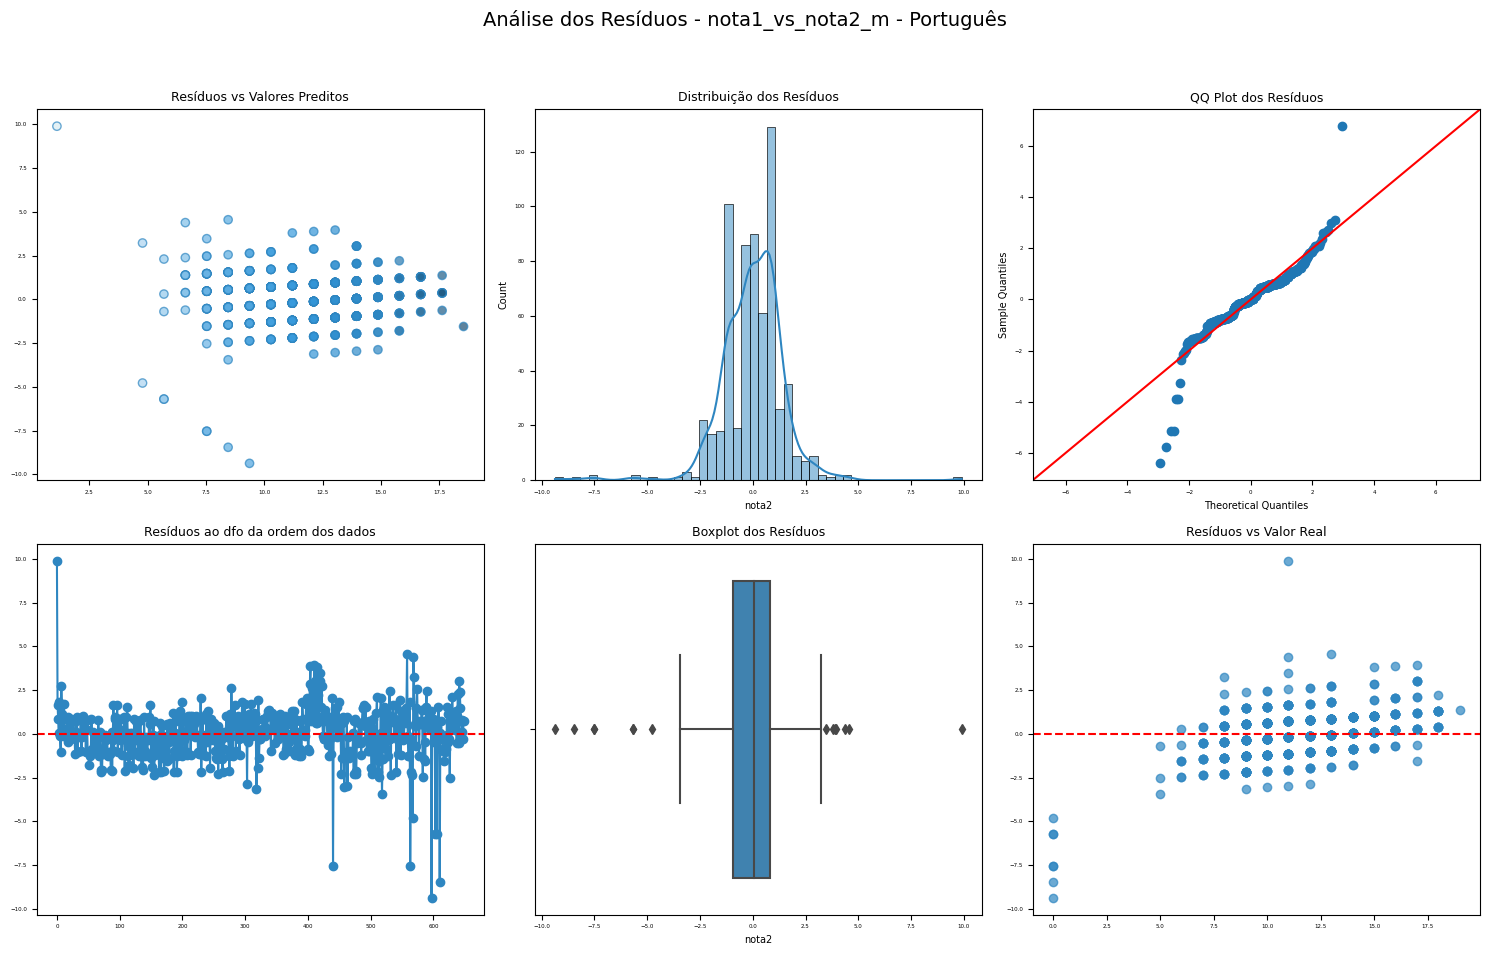

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,4.926722e-16,0.895378,Não normal,1.404065e-09,Heteroscedástico,1.669422,OK,10


In [12]:
aux_drop = ['nota2','nota_final']

variaveis = list(set(df_o.columns) - set(aux_drop))

modelo_m = regressao_multipla(df_o, target='nota2', variaveis=['nota1'])
print(modelo_m.summary())

avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_nota2_m', materia=materia)


##### Modelo extraíndo atributos com multicolineariedade

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     55.96
Date:                Tue, 06 May 2025   Prob (F-statistic):          2.45e-168
Time:                        04:53:39   Log-Likelihood:                -1141.8
No. Observations:                 649   AIC:                             2358.
Df Residuals:                     612   BIC:                             2523.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

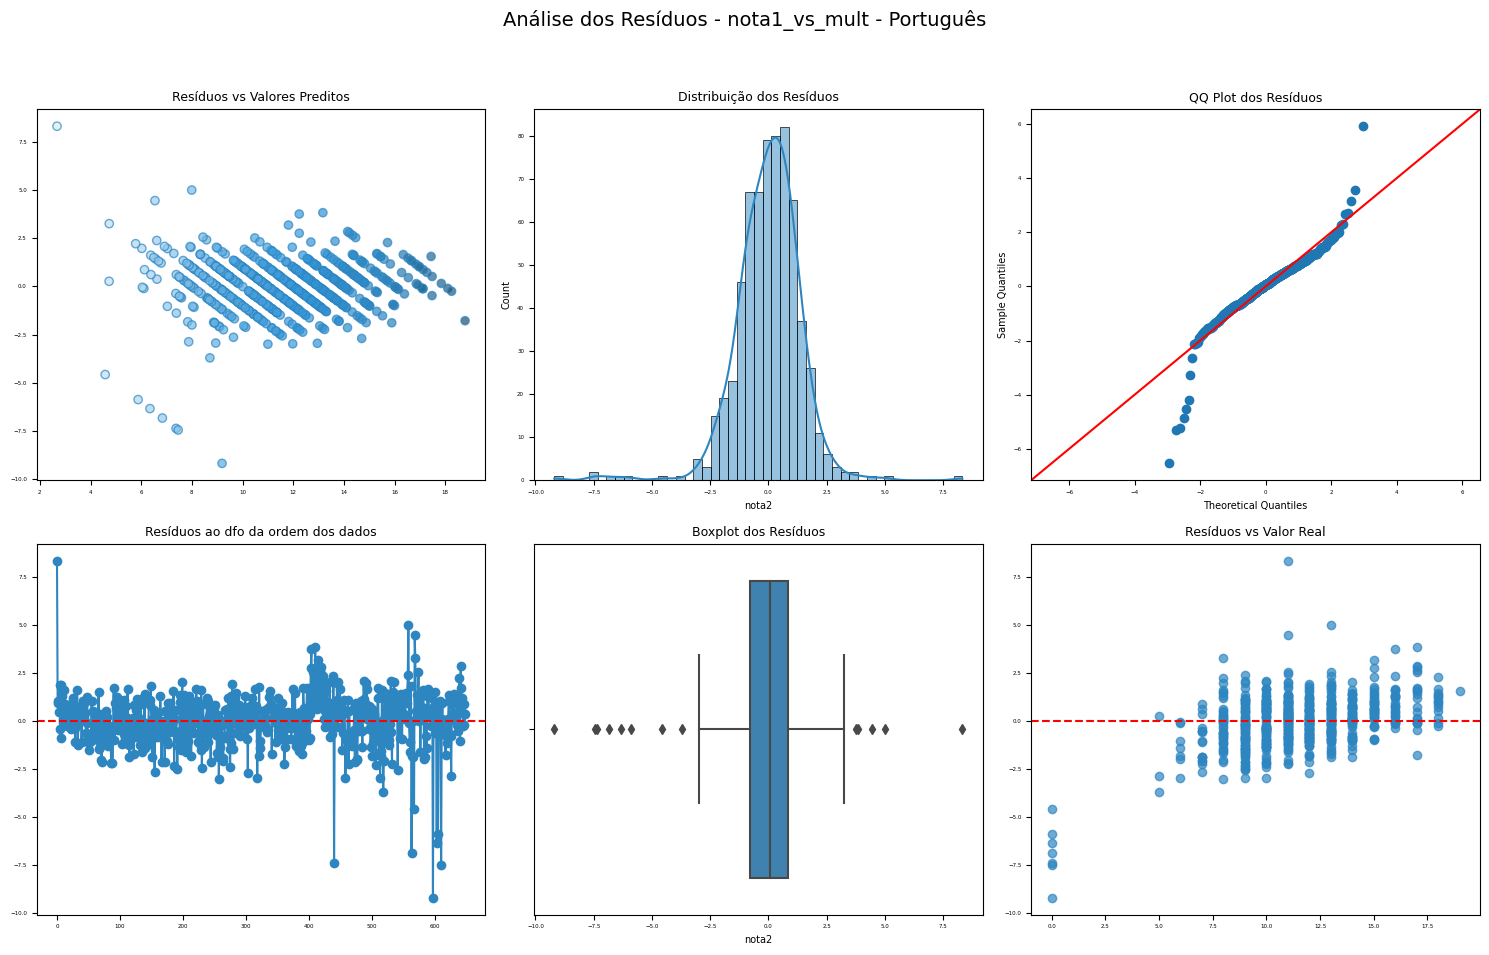

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,5.315385e-14,0.909029,Não normal,2.824939e-09,Heteroscedástico,1.764909,OK,10


In [13]:
aux_drop = ['nota2','nota_final']

variaveis = list(set(df_o.columns) - set(variaveis_alta_colineariedade) - set(aux_drop))

modelo_m = regressao_multipla(df_o.drop(columns=['nota_final']+ variaveis_alta_colineariedade),
                               target='nota2', variaveis=variaveis)

print(modelo_m.summary())

avaliar_residuos_regressao(df['nota2'], modelo_m.predict(), nome_modelo='nota1_vs_mult', materia=materia)



# 5. Regressão com variáveis não relacionadas às notas
- Objetivo: Investigar a contribuição de fatores socioeconômicos e escolares na nota final.

In [14]:
df_vnr = df_pp.drop(columns=['nota1','nota2'])

## 5.2 Regressão: variáveis explicativas (sem notas) -> nota_final

                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     8.797
Date:                Tue, 06 May 2025   Prob (F-statistic):           3.27e-38
Time:                        04:53:40   Log-Likelihood:                -1536.5
No. Observations:                 649   AIC:                             3153.
Df Residuals:                     609   BIC:                             3332.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

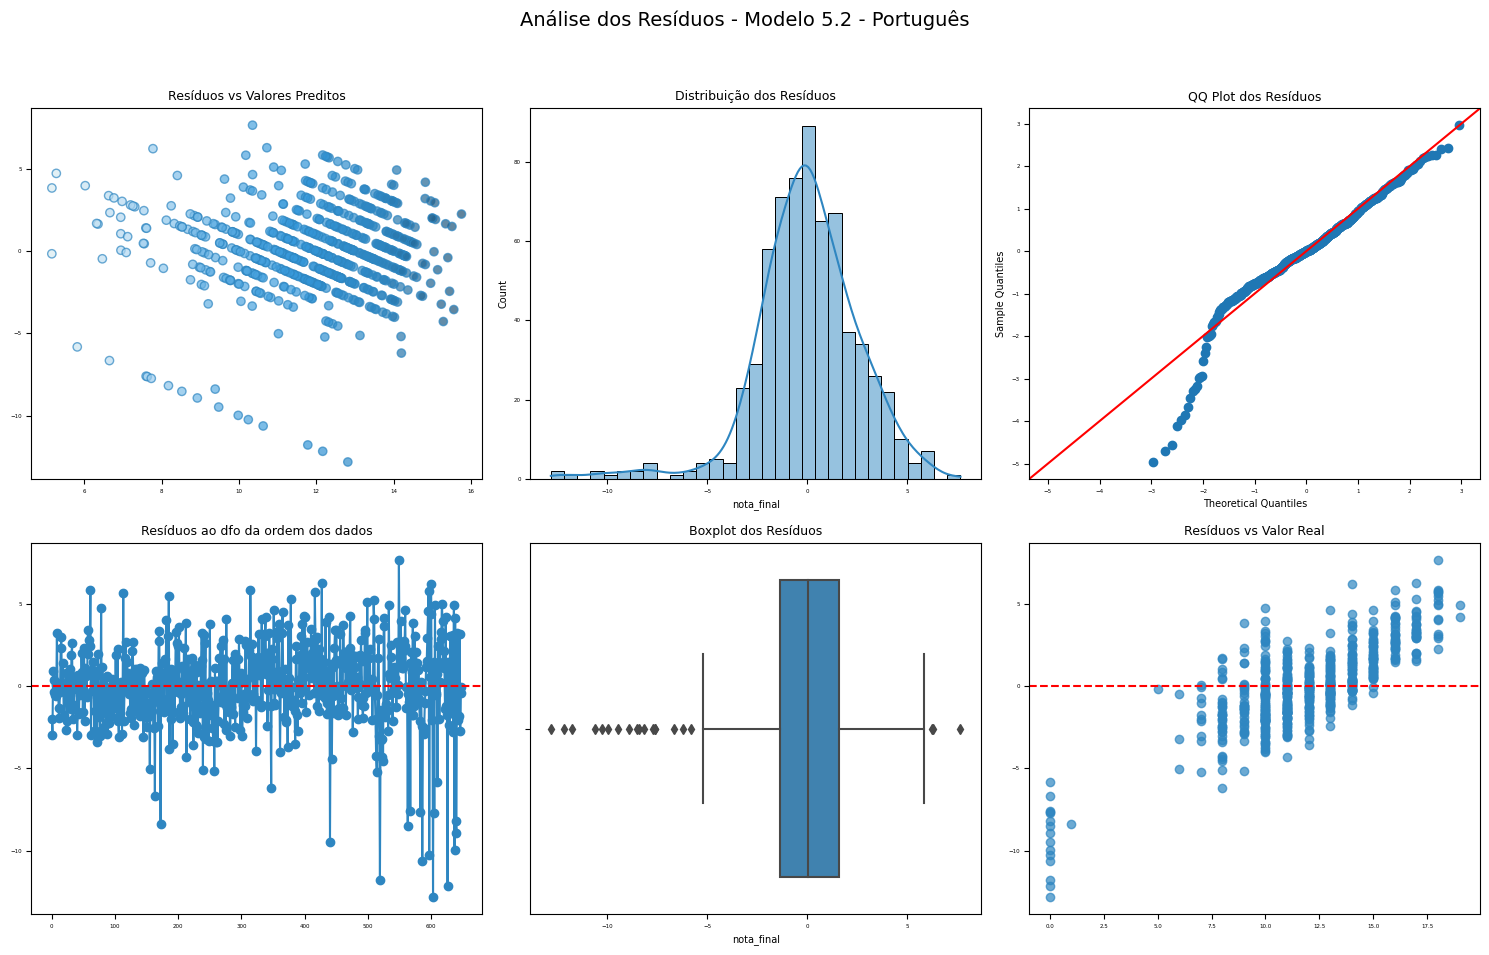

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,3.201274e-14,0.942661,Não normal,0.002045,Heteroscedástico,1.926022,OK,11


In [15]:
aux_drop = ['nota_final']

variaveis = list(set(df_vnr.columns) - set(aux_drop)) 

modelo_m = regressao_multipla(df_vnr, target='nota_final', variaveis=variaveis)
print(modelo_m.summary())

avaliar_residuos_regressao(df_vnr['nota_final'], modelo_m.predict(), 
                           nome_modelo='Modelo 5.2', materia=materia)


##### Modelo extraíndo atributos com multicolineariedade

                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     9.637
Date:                Tue, 06 May 2025   Prob (F-statistic):           3.63e-39
Time:                        04:53:41   Log-Likelihood:                -1539.2
No. Observations:                 649   AIC:                             3150.
Df Residuals:                     613   BIC:                             3312.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

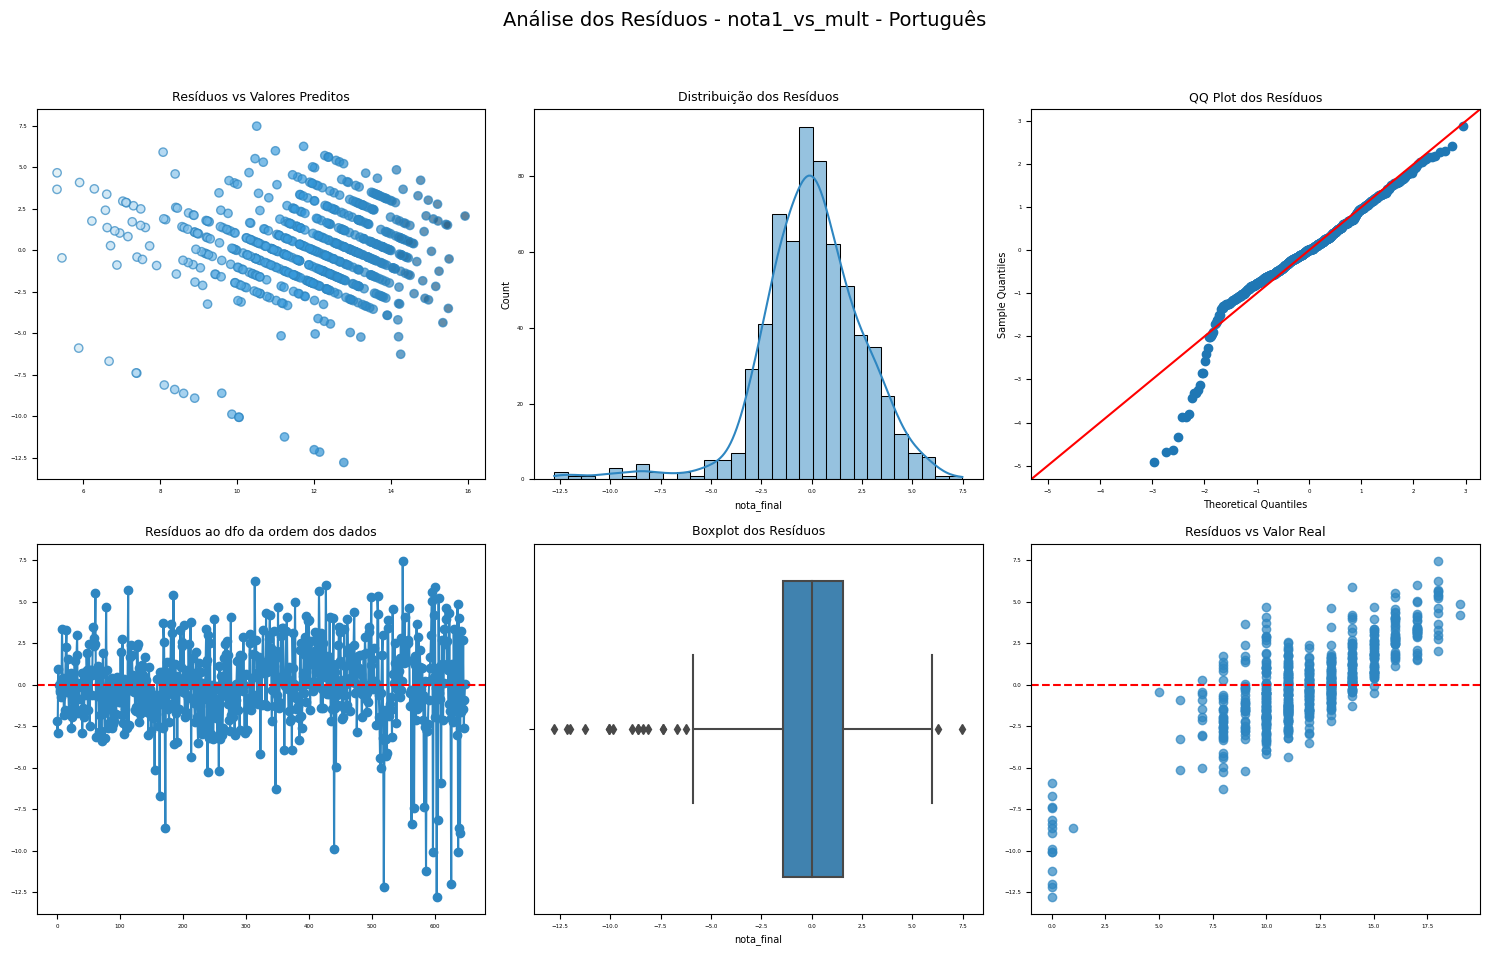

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,6.190152e-14,0.940221,Não normal,0.00341,Heteroscedástico,1.90087,OK,12


In [16]:

variaveis = list(set(df_vnr.columns) - set(variaveis_alta_colineariedade) - set(aux_drop))

modelo_m = regressao_multipla(df_vnr,
                               target='nota_final', variaveis=variaveis)

print(modelo_m.summary())

avaliar_residuos_regressao(df_vnr['nota_final'], modelo_m.predict(), 
                           nome_modelo='nota1_vs_mult', materia=materia)




Seleção stepwise (significância estatística)
 - Aplicação do método Stepwise para selecionar variáveis estatisticamente relevantes.
 - Compara-se com o modelo automático de top_n e análise de resíduos.

In [17]:
variaveis_sem_nota = df_vnr.drop(columns='nota_final').columns

Variáveis selecionadas pelo stepwise: ['reprovacoes', 'escola_Mousinho da Silveira', 'intencao_superior', 'tempo_estudo', 'apoio_escolar', 'alcool_dias_uteis', 'saude', 'escolaridade_pai', 'genero_Mulher']
                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     33.55
Date:                Tue, 06 May 2025   Prob (F-statistic):           1.96e-48
Time:                        04:53:42   Log-Likelihood:                -1555.9
No. Observations:                 649   AIC:                             3132.
Df Residuals:                     639   BIC:                             3177.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
    

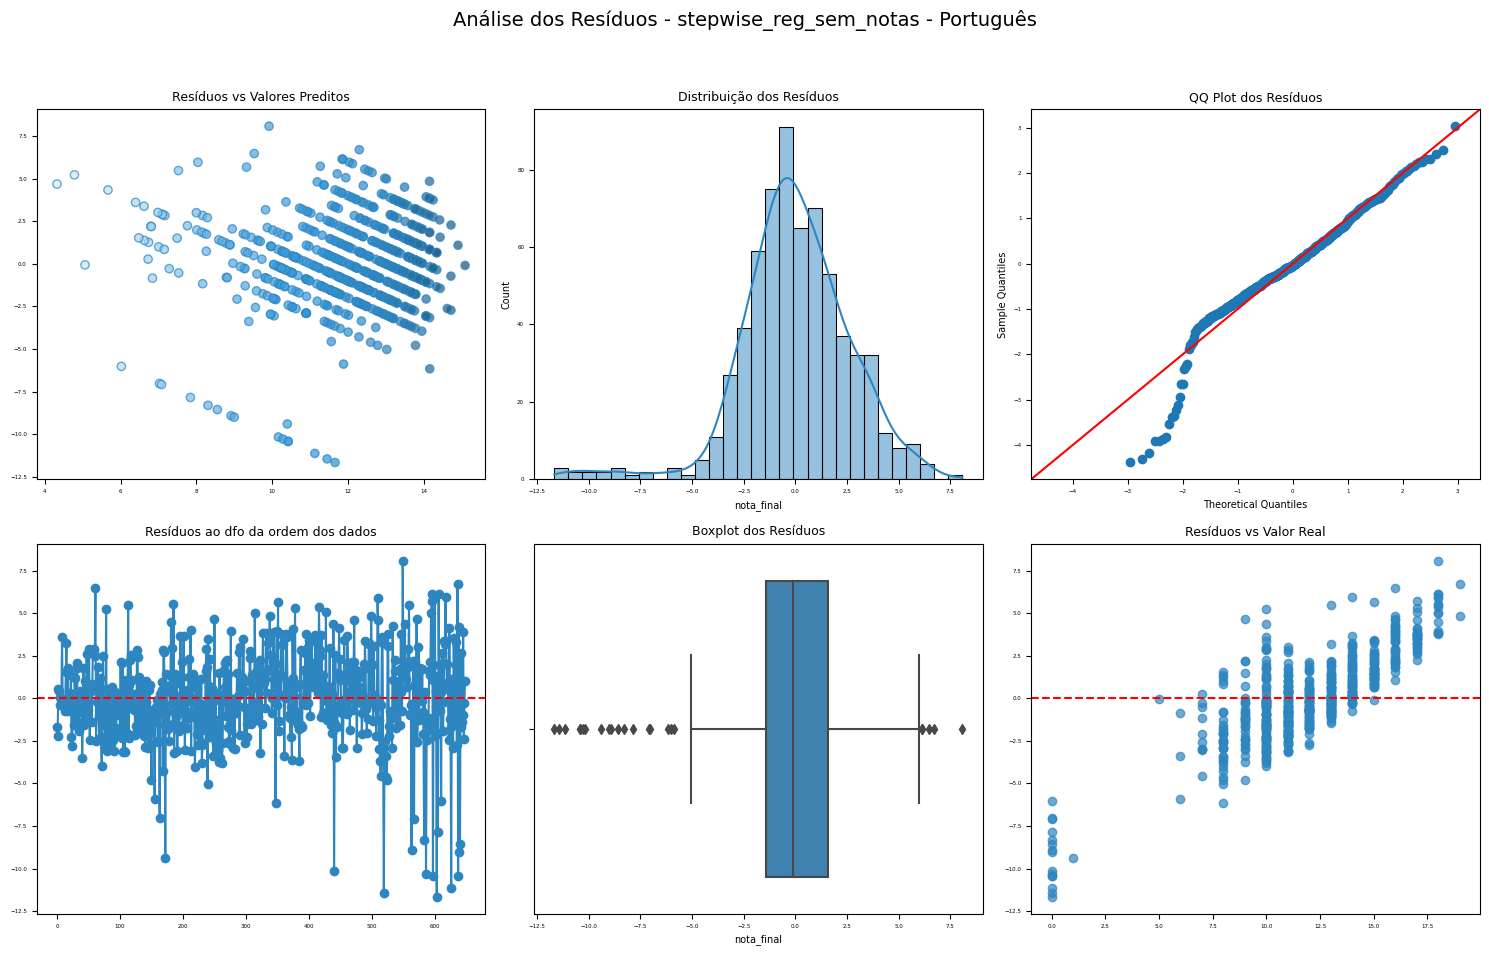

,Média dos Resíduos,Shapiro-Wilk Estatística,Normalidade (Shapiro-Wilk),p-valor Breusch-Pagan,Homoscedasticidade,Durbin-Watson,Autocorrelação,Outliers (|z| > 3)
0,2.699843e-14,0.950875,Não normal,0.000023,Heteroscedástico,1.916233,OK,13


In [18]:
variaveis_step = stepwise_selection(df_vnr, target='nota_final', variaveis_candidatas=variaveis_sem_nota)

print(f"Variáveis selecionadas pelo stepwise: {variaveis_step}")

modelo_step = regressao_multipla(df_vnr, target='nota_final', variaveis=variaveis_step)
print(modelo_step.summary())

avaliar_residuos_regressao(df_vnr['nota_final'], modelo_step.predict(), 
                           nome_modelo='stepwise_reg_sem_notas', materia=materia)

# 6. Testes estatísticos para seleção de atributos

In [19]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'intencao_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


## 6.1. Testes para variáveis ordinais
- Aplicação de testes não paramétricos para avaliar associação com desempenho.

In [20]:
selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Variáveis ordinais relevantes com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.448,2.05e-33,130.659,3.90e-28
0,escolaridade_mae,0.284,1.69e-13,57.215,1.12e-11
6,tempo_estudo,0.275,1.06e-12,50.316,6.84e-11
1,escolaridade_pai,0.235,1.44e-09,36.785,1.99e-07
8,alcool_dias_uteis,-0.208,8.43e-08,29.665,5.73e-06
9,alcool_fim_semana,-0.171,1.20e-05,24.297,6.96e-05
7,tempo_transporte,-0.147,0.0,14.751,0.002
3,tempo_livre,-0.128,0.001,19.546,0.001
5,saude,-0.106,0.007,10.997,0.027
4,frequencia_saidas,-0.105,0.007,19.766,0.001


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.448,2.05e-33,130.659,3.90e-28
0,escolaridade_mae,0.284,1.69e-13,57.215,1.12e-11
6,tempo_estudo,0.275,1.06e-12,50.316,6.84e-11
1,escolaridade_pai,0.235,1.44e-09,36.785,1.99e-07
8,alcool_dias_uteis,-0.208,8.43e-08,29.665,5.73e-06
9,alcool_fim_semana,-0.171,1.20e-05,24.297,6.96e-05
7,tempo_transporte,-0.147,0.0,14.751,0.002
3,tempo_livre,-0.128,0.001,19.546,0.001
5,saude,-0.106,0.007,10.997,0.027
4,frequencia_saidas,-0.105,0.007,19.766,0.001



## 6.2. Testes para variáveis nominais
- Aplicação de testes de independência para verificar significância de categorias nominais.

### 6.2.1 Aplicação nas variáveis nominais antes do onehotencoding

In [21]:
selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0)

Variáveis com P-Value < 0.05 e Coeficiente de Contingência > 0.00, ordenadas por Coeficiente de Contingência:


,Variable,P-Value,Contingency Coefficient
14,reprovacoes,1.05e-22,0.403
4,intencao_superior,1.22e-14,0.303
0,escola,8.81e-14,0.293
7,escolaridade_pai,8.16e-05,0.192
6,escolaridade_mae,0.0,0.178
8,relacao_familiar,0.001,0.172
11,tempo_estudo,0.0,0.172
3,motivo_escolha_escola,0.0,0.166
10,frequencia_saidas,0.002,0.161
12,alcool_dias_uteis,0.019,0.135


['reprovacoes',
 'intencao_superior',
 'escola',
 'escolaridade_pai',
 'escolaridade_mae',
 'relacao_familiar',
 'tempo_estudo',
 'motivo_escolha_escola',
 'frequencia_saidas',
 'alcool_dias_uteis',
 'tempo_livre',
 'profissao_mae',
 'endereco',
 'alcool_fim_semana',
 'acesso_internet']

### 6.2.1 Aplicação nas variáveis nominais após do onehotencoding

In [22]:
v_c = pd.get_dummies(
    df[list(set(variaveis_categoricas_nominais) - {'aprovacao'})],
    drop_first=False
).columns.tolist()


variaveis_dummies_nominais = [col for col in df_pc.columns if col in v_c]


In [23]:
variaveis_dummies_nominais

['tamanho_familia',
 'apoio_escolar',
 'apoio_familiar',
 'aulas_particulares',
 'atividades_extracurriculares',
 'frequentou_creche',
 'intencao_superior',
 'acesso_internet',
 'relacionamento_romantico',
 'escola_Mousinho da Silveira',
 'genero_Mulher',
 'endereco_Urbano',
 'status_parental_Separados',
 'profissao_mae_Outra profissão',
 'profissao_mae_Professor(a)',
 'profissao_mae_Serviços',
 'profissao_mae_Área da saúde',
 'profissao_pai_Outra profissão',
 'profissao_pai_Professor(a)',
 'profissao_pai_Serviços',
 'profissao_pai_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'motivo_escolha_escola_Próximo de casa',
 'motivo_escolha_escola_Reputação da escola',
 'responsavel_legal_Outro responsável',
 'responsavel_legal_Pai']

In [24]:
type(df_pc)


pandas.core.frame.DataFrame

In [25]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# 1. Seleção das variáveis categóricas binárias (sem vírgula!)
X_cat_bin_only = df_pc[variaveis_dummies_nominais]

# 2. Aplicar SelectKBest com chi2
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_cat_bin_only, y=df_pc['aprovacao'])

# 3. Obter resultados
scores = selector_chi2.scores_
p_values = selector_chi2.pvalues_

chi2_results = pd.DataFrame({
    'Feature': X_cat_bin_only.columns,
    'Chi2_Score': scores,
    'P_Value': p_values
}).sort_values(by='P_Value', ascending=True)

# 4. Mostrar resultados
print("\nResultados do Teste Qui-Quadrado (ordenado por P-Valor):")
display(chi2_results)

# 5. Selecionar features significativas
alpha = 0.05
significant_features_chi2 = chi2_results[chi2_results['P_Value'] < alpha]['Feature'].tolist()

print(f"\nFeatures categóricas/binárias com P-Valor < {alpha} (consideradas significativas):")
print(significant_features_chi2)






Resultados do Teste Qui-Quadrado (ordenado por P-Valor):


,Feature,Chi2_Score,P_Value
9,escola_Mousinho da Silveira,37.366976,9.786528e-10
23,motivo_escolha_escola_Reputação da escola,7.769511,5.313543e-03
6,intencao_superior,6.618406,1.009301e-02
14,profissao_mae_Professor(a),5.362481,2.057448e-02
21,motivo_escolha_escola_Outro motivo,5.082049,2.417478e-02
11,endereco_Urbano,3.160563,7.543717e-02
25,responsavel_legal_Pai,2.877133,8.984585e-02
8,relacionamento_romantico,2.701764,1.002373e-01
22,motivo_escolha_escola_Próximo de casa,1.828057,1.763572e-01
3,aulas_particulares,1.759601,1.846743e-01



Features categóricas/binárias com P-Valor < 0.05 (consideradas significativas):
['escola_Mousinho da Silveira', 'motivo_escolha_escola_Reputação da escola', 'intencao_superior', 'profissao_mae_Professor(a)', 'motivo_escolha_escola_Outro motivo']


In [26]:
df_pc['aprovacao'].value_counts()

1    549
0    100
Name: aprovacao, dtype: int64

In [27]:
df_processado_class.columns

NameError: name 'df_processado_class' is not defined

In [ ]:
df_processado_class['aprovacao']

Series([], Name: aprovacao, dtype: float64)

In [ ]:
df_pp['aprovacao'].value_counts()

Series([], Name: aprovacao, dtype: int64)

In [ ]:
df_pp[variaveis_dummies_nominais].head()

,escola_Mousinho da Silveira,genero_Mulher,endereco_Urbano,status_parental_Separados,profissao_mae_Outra profissão,profissao_mae_Professor(a),profissao_mae_Serviços,profissao_mae_Área da saúde,profissao_pai_Outra profissão,profissao_pai_Professor(a),profissao_pai_Serviços,profissao_pai_Área da saúde,motivo_escolha_escola_Outro motivo,motivo_escolha_escola_Próximo de casa,motivo_escolha_escola_Reputação da escola,responsavel_legal_Outro responsável,responsavel_legal_Pai
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
colunas_constantes = X_cat_bin_only.columns[X_cat_bin_only.nunique() <= 1]
print("Colunas constantes:", colunas_constantes.tolist())


Colunas constantes: []


In [ ]:
print(X_cat_bin_only.dtypes.value_counts())


float64    17
dtype: int64


# 7. Análise exploratória multivariada (PCA e Clusterização)

In [ ]:

# Seleção dos dados 
X = df_pp[variaveis_sem_nota].dropna()
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


### Definindo o número de clusters

**Estimando o número de Clusters Ideiais - Elbow Method**

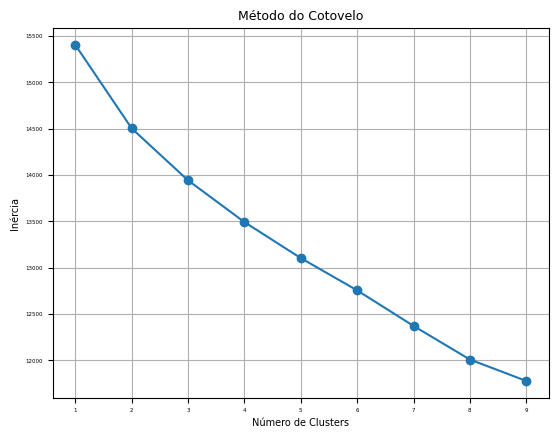

In [ ]:
# Avaliação da quantidade ideal de clusters
inercia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 10), inercia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()


**Estimando o número de Clusters Ideiais - silhouette score Method**

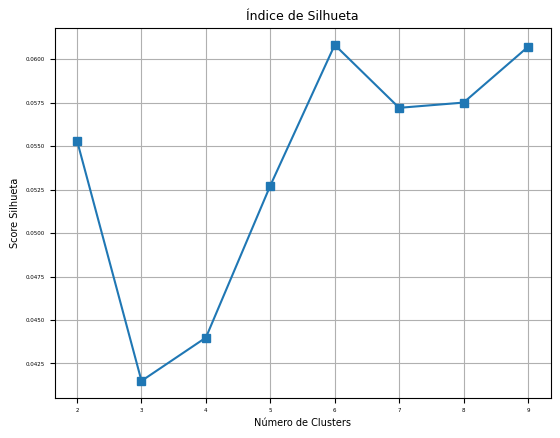

In [ ]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append(score)

plt.plot(range(2, 10), scores, marker='s')
plt.title('Índice de Silhueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Score Silhueta')
plt.grid(True)
plt.show()


## **Análise (n_clusters = 2)**
- Objetivo: Verificar se há perfis de alunos similares com base nas variáveis selecionadas.

In [ ]:


# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)





In [ ]:
# 2 Cluster
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualização
df_cluster = df.copy()
df_cluster['cluster'] = clusters
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]


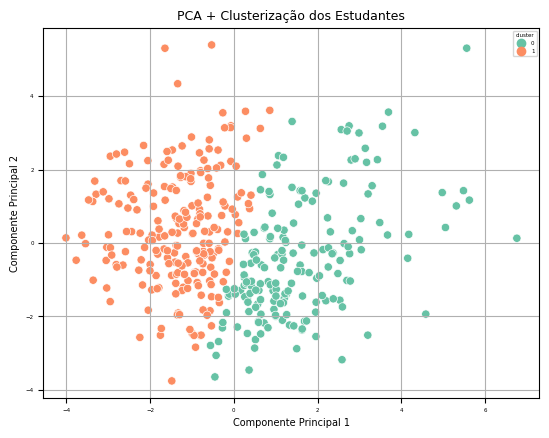

In [ ]:
sns.scatterplot(data=df_cluster, x='PCA1', y='PCA2', hue='cluster', palette='Set2')
plt.title('PCA + Clusterização dos Estudantes')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

In [ ]:
plot_boxplot_countplot(df_cluster,x='cluster',
                       y='nota_final',
                       materia= materia,
                       nome_arquivo='pca_cluster',
                       paleta=cor_paleta,
                       hue='aprovacao')

NameError: name 'df_cluster' is not defined

**Avaliando os Atributos de Maior Influência no PCA**

Metodologia - Significância estatística sob controle de covariáveis  

- Após a avaliação dos modelos, será possível investigar se os parâmetros quantitativos se mantêm ou se diferenciam.  
- Avaliação futura com PCA pode ser considerada para detectar padrões latentes nos dados.  

In [ ]:
# Obtém os pesos (loadings) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Componente {i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Exibe os top atributos que mais influenciam o PCA
display(loadings.sort_values(by='Componente 1', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 2', key=abs, ascending=False).head(10))


,Componente 1,Componente 2
escolaridade_mae,-0.353709,0.232328
escolaridade_pai,-0.333011,0.226621
idade,0.267024,0.050558
reprovacoes,0.262712,0.072241
intencao_superior,-0.208969,-0.102003
escola_Mousinho da Silveira,0.207746,0.062188
profissao_mae_Professor(a),-0.203897,0.236436
apoio_familiar,-0.202186,-0.021757
alcool_fim_semana,0.200054,0.366197
tempo_transporte,0.192989,0.018724


,Componente 1,Componente 2
alcool_dias_uteis,0.176966,0.378820
alcool_fim_semana,0.200054,0.366197
genero_Mulher,-0.093383,-0.292520
profissao_pai_Outra profissão,0.146971,-0.251724
frequencia_saidas,0.087446,0.244699
profissao_mae_Outra profissão,0.179804,-0.238704
profissao_mae_Professor(a),-0.203897,0.236436
escolaridade_mae,-0.353709,0.232328
tempo_estudo,-0.169922,-0.229865
escolaridade_pai,-0.333011,0.226621


## **Análise (n_clusters = 3)**
- Objetivo: Verificar se há perfis de alunos similares com base nas variáveis selecionadas.

In [ ]:


# PCA (Análise de Componentes Principais)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)





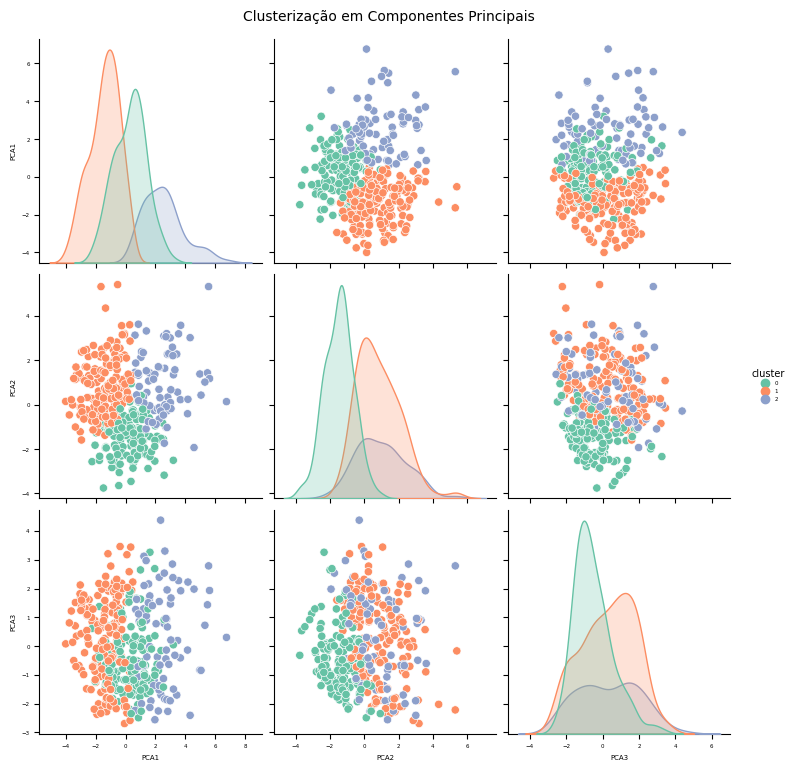

In [ ]:
# 3 Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Visualização
df_cluster = df.copy()
df_cluster['cluster'] = clusters
df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]
df_cluster['PCA3'] = X_pca[:, 2]

sns.pairplot(df_cluster, vars=['PCA1', 'PCA2', 'PCA3'], hue='cluster', palette='Set2')
plt.suptitle('Clusterização em Componentes Principais', y=1.02)
plt.show()

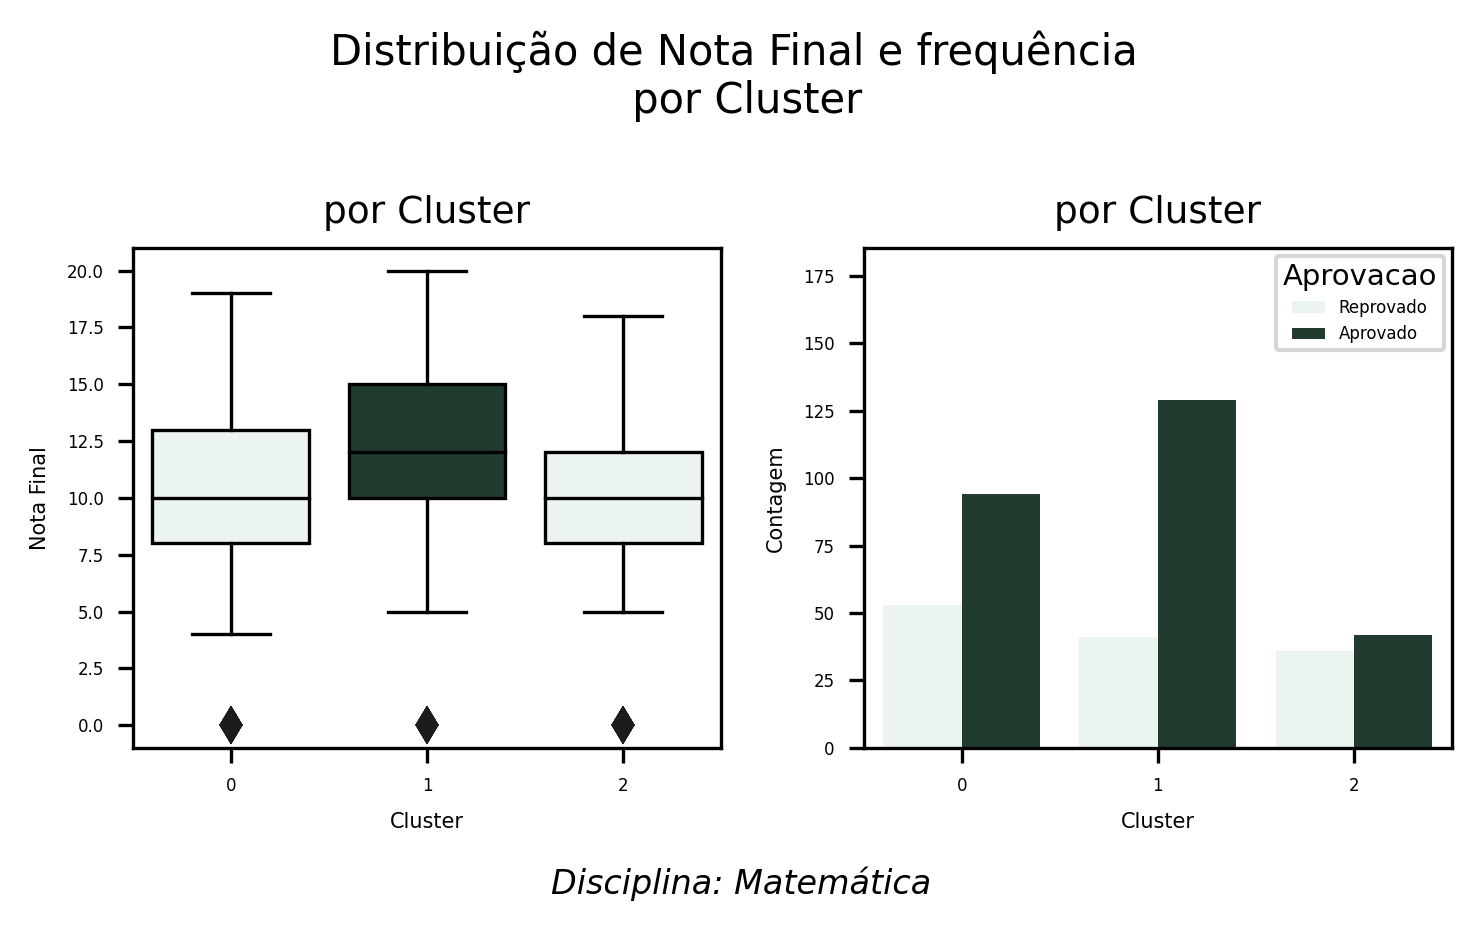

In [ ]:
plot_boxplot_countplot(df_cluster,x='cluster',
                       y='nota_final',
                       materia= materia,
                       nome_arquivo='pca_cluster',
                       paleta=cor_paleta,
                       hue='aprovacao')

**Avaliando os Atributos de Maior Influência no PCA**

Metodologia - Significância estatística sob controle de covariáveis  

- Após a avaliação dos modelos, será possível investigar se os parâmetros quantitativos se mantêm ou se diferenciam.  
- Avaliação futura com PCA pode ser considerada para detectar padrões latentes nos dados.  

In [ ]:
# Obtém os pesos (loadings) dos componentes principais
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Componente {i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Exibe os top atributos que mais influenciam o PCA
display(loadings.sort_values(by='Componente 1', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 2', key=abs, ascending=False).head(10))
display(loadings.sort_values(by='Componente 3', key=abs, ascending=False).head(10))


,Componente 1,Componente 2,Componente 3
escolaridade_mae,-0.353709,0.232328,-0.120472
escolaridade_pai,-0.333011,0.226621,-0.036872
idade,0.267024,0.050558,0.178203
reprovacoes,0.262712,0.072241,0.160234
intencao_superior,-0.208969,-0.102003,-0.122128
escola_Mousinho da Silveira,0.207746,0.062188,0.167155
profissao_mae_Professor(a),-0.203897,0.236436,-0.102054
apoio_familiar,-0.202186,-0.021757,-0.020137
alcool_fim_semana,0.200054,0.366197,-0.184641
tempo_transporte,0.192989,0.018724,-0.010180


,Componente 1,Componente 2,Componente 3
alcool_dias_uteis,0.176966,0.378820,-0.116949
alcool_fim_semana,0.200054,0.366197,-0.184641
genero_Mulher,-0.093383,-0.292520,0.226236
profissao_pai_Outra profissão,0.146971,-0.251724,-0.491690
frequencia_saidas,0.087446,0.244699,-0.185928
profissao_mae_Outra profissão,0.179804,-0.238704,-0.245989
profissao_mae_Professor(a),-0.203897,0.236436,-0.102054
escolaridade_mae,-0.353709,0.232328,-0.120472
tempo_estudo,-0.169922,-0.229865,0.138679
escolaridade_pai,-0.333011,0.226621,-0.036872


,Componente 1,Componente 2,Componente 3
profissao_pai_Outra profissão,0.146971,-0.251724,-0.491690
profissao_pai_Serviços,0.000794,0.208412,0.470061
profissao_mae_Serviços,-0.038224,0.108773,0.271655
profissao_mae_Outra profissão,0.179804,-0.238704,-0.245989
genero_Mulher,-0.093383,-0.292520,0.226236
frequencia_saidas,0.087446,0.244699,-0.185928
alcool_fim_semana,0.200054,0.366197,-0.184641
tempo_livre,0.078274,0.215961,-0.179691
idade,0.267024,0.050558,0.178203
escola_Mousinho da Silveira,0.207746,0.062188,0.167155
